<a href="https://colab.research.google.com/github/centzh/fastai-projects/blob/main/california_piers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting piers in California

**Setup**

In this section, we set up the notebook by importing relevant libraries and preparing the directory that will hold our data.

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 83.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.
Mounted at /content/gdrive


In [2]:
# Create a directory named 'piers'
piers_dir = Path('piers')

# Check if the directory already exists
if not piers_dir.exists():
  piers_dir.mkdir()  # Create the directory if it x

**Data**

In this section, we retrieve the image data for each of the three search prompts (i.e. piers). These prompts will be the classes for our classification problem.

In [3]:
piers = ['Santa Monica Pier', 'Huntington Beach Pier', 'Hermoso Beach Pier']

for pier in piers:
  # Search for images of Santa Monica Pier using duck-duck-go
  ims = search_images_ddg(pier)

  # Create a sub-directory to store images of Santa Monica pier
  sub_dir = piers_dir / pier # Use path joining
  if not sub_dir.exists():
    sub_dir.mkdir()  # Create the subdirectory

  # Download the images from the search and place into the sub-directory
  download_images(sub_dir, urls=ims)

  # Get the image files in the directory
  fns = get_image_files(sub_dir) # Every element is a Path object

  # Check if there are any downloaded_files that are corrupt
  failed = verify_images(fns) # Verify images returns an object of type L, which includes a map method
  print(f"There were {len(failed)} failed images") # Use f-string in Python

  # Remove all the failed images - this does the removal
  failed.map(Path.unlink) # Path.unlink operates on each of the failed image paths


There were 3 failed images
There were 4 failed images
There were 3 failed images


Here we pre-process the dataset by applying item and batch transformations.
- For item transformations, we randomly select a part of each image and crop to just that part. This lets the model focus on and recognise different features in the images.
- For batch transformations, we apply data augmentation on each batch. Data augmentation is the process of introducing random variations to the input data, such as through rotation, flipping and brightness and contrast changes.


In [4]:
# Create the DataBlock object - this is a template for creating a DataLoaders
# Note: You need to have commas separating each of the arguments
piers = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # Independent is Image, Dependent is Category Label
    get_items=get_image_files, # Takes a path and returns list of all images in that path - this is executed each time the DataBlock is run
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # Split items between train/val with 20% validation set randomly
    get_y=parent_label, # Assign the name of the parent directory as the label for each of these images
    item_tfms=Resize(128))  # Resize each of the images

In [5]:
# Specify the actual source of data and create the data loaders
dls = piers.dataloaders(piers_dir)

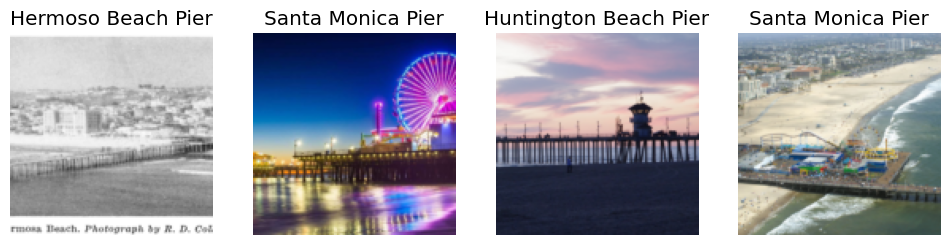

In [6]:
dls.valid.show_batch(max_n=4, nrows=1)

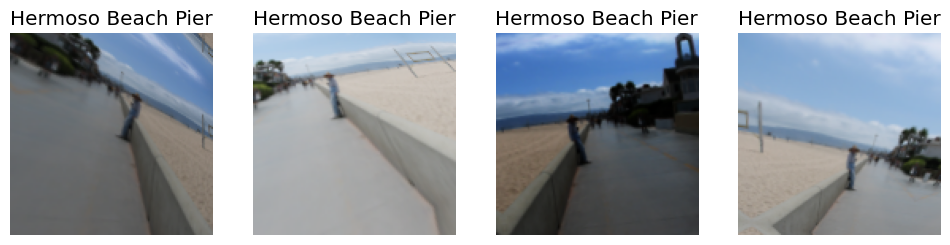

In [17]:
# What if you do item_tmfs here, what does batch_tfms actually mean practically, what difference is there to item_tfms
piers = piers.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2)) # Create a new datablock with other item_tfms and batch_tfms
dls = piers.dataloaders(piers_dir)
dls.train.show_batch(max_n=4, nrows=1, unique=True)  # Fast.AI will give you a batch of 64 ages at a time, by default

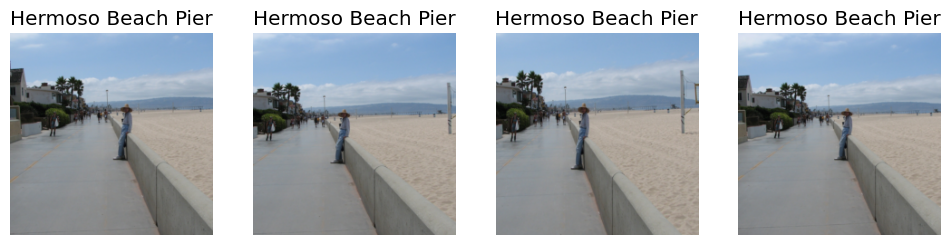

In [19]:
piers = piers.new(item_tfms=RandomResizedCrop(224, min_scale=0.5))
dls = piers.dataloaders(piers_dir)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [20]:
# Create our vision learner
learn = vision_learner(dls, resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 148MB/s]


In [21]:
learn.fine_tune(4)  # Run for 4 epochs

epoch,train_loss,valid_loss,error_rate,time
0,1.535524,0.989932,0.355769,00:22


epoch,train_loss,valid_loss,error_rate,time
0,0.764019,0.504892,0.192308,00:21
1,0.610667,0.345945,0.105769,00:25
2,0.468762,0.309748,0.076923,00:26
3,0.368088,0.317510,0.086538,00:24


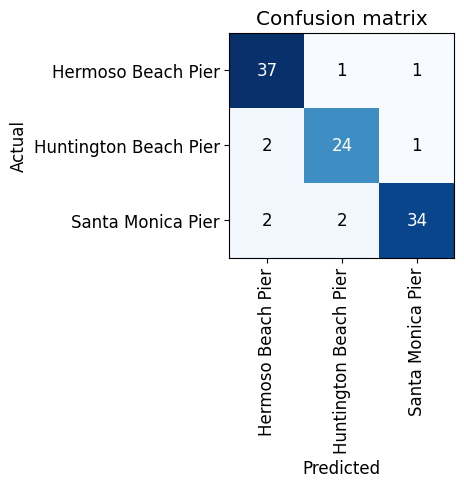

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [41]:
confusion_matrix = interp.confusion_matrix()

In [42]:
correct = np.trace(confusion_matrix)
correct

95

In [43]:
total = np.sum(confusion_matrix)
total

104

In [44]:
accuracy = correct / total
print(f"The overall accuracy of the model is {accuracy}")

The overall accuracy of the model is 0.9134615384615384


In [45]:
interp.print_classification_report()

                       precision    recall  f1-score   support

   Hermoso Beach Pier       0.90      0.95      0.92        39
Huntington Beach Pier       0.89      0.89      0.89        27
    Santa Monica Pier       0.94      0.89      0.92        38

             accuracy                           0.91       104
            macro avg       0.91      0.91      0.91       104
         weighted avg       0.91      0.91      0.91       104



In [46]:
test_im_path = 'santa-monica-pier-test.jpg'
learn.predict(test_im_path)

('Santa Monica Pier', tensor(2), tensor([1.4937e-04, 2.9919e-05, 9.9982e-01]))

**Export model**

In this section, we export the model for future use.




In [47]:
learn.export()

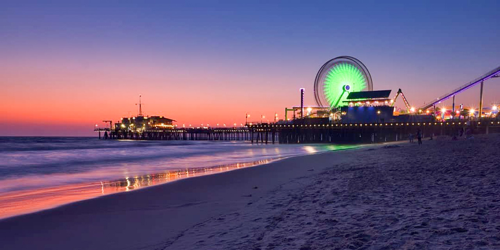

In [48]:
# Open the image using the Image module in PIL
test_im_path = 'santa-monica-pier-test.jpg'
im = Image.open(test_im_path)
im.to_thumb(500, 500)

In [49]:
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')
learn_inf.predict(test_im_path)

('Santa Monica Pier', tensor(2), tensor([1.4937e-04, 2.9918e-05, 9.9982e-01]))